## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [ ]:
# TODO: change to numbered version after it's released
# !pip install -q tflite-model-maker
# !pip install tflite-model-maker
!pip install tflite-model-maker-nightly
!pip install -q pycocotools

     |████████████████████████████████| 573kB 19.7MB/s 
     |████████████████████████████████| 112kB 53.4MB/s 
     |████████████████████████████████| 645kB 53.1MB/s 
     |████████████████████████████████| 133kB 55.8MB/s 
     |████████████████████████████████| 454.8MB 36kB/s 
     |████████████████████████████████| 1.1MB 45.0MB/s 
     |████████████████████████████████| 5.5MB 43.8MB/s 
     |████████████████████████████████| 849kB 51.1MB/s 
     |████████████████████████████████| 122kB 61.7MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 174kB 58.0MB/s 
     |████████████████████████████████| 1.2MB 48.7MB/s 
     |████████████████████████████████| 655kB 56.5MB/s 
     |████████████████████████████████| 4.0MB 39.4MB/s 
     |████████████████████████████████| 471kB 58.9MB/s 
     |████████████████████████████████| 4.0MB 44.2MB/s 
     |████████████████████████████████| 1.2MB 49.5MB/s 
     |████████████████████████████████| 6.0MB 35.

Import the required packages.

In [ ]:
import numpy as np
import os, glob
from urllib import request
from zipfile import ZipFile
from io import BytesIO
import pandas as pd

# from tflite_model_maker import configs
from tensorflow_examples.lite.model_maker.core.task import configs
# from tflite_model_maker import ExportFormat
from tensorflow_examples.lite.model_maker.core import export_format as ExportFormat
from tflite_model_maker import model_spec
# from tflite_model_maker import object_detector
from tensorflow_examples.lite.model_maker.core.task import object_detector 
# from tflite_model_maker import ObjectDetectorDataloader
from tensorflow_examples.lite.model_maker.core.data_util import object_detector_dataloader as ObjectDetectorDataloader

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
DATASETS_DIR = './datasets'
TRAIN_DIR = DATASETS_DIR + '/train'
VALID_DIR = DATASETS_DIR + '/valid'
TEST_DIR = DATASETS_DIR + '/test'
ROBOFLOW_TFRECORD_URL = 'https://app.roboflow.com/ds/2zxrnF1EjG?key=CjL3YRU9An'


if not os.path.exists(DATASETS_DIR):
    os.makedirs(DATASETS_DIR)

if not os.path.exists(DATASETS_DIR + './README.roboflow.txt'):
    http_response = request.urlopen(ROBOFLOW_TFRECORD_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DATASETS_DIR)
    

In [ ]:
all_csv_files = glob.glob(DATASETS_DIR + '/*/*.csv')

temp_df = []

for f in all_csv_files:
    dir_type = f.split('_')[0]
    dfs = pd.read_csv(f)
    dfs['filenamefull'] = dir_type + dfs['filename']

    dfs['fxmin'] = dfs['xmin']/dfs['width']
    dfs['fxmax'] = dfs['xmax']/dfs['width']
    dfs['fymin'] = dfs['ymin']/dfs['height']
    dfs['fymax'] = dfs['ymax']/dfs['height']

    if 'train' in dir_type: data_type = 'TRAINING'
    elif 'test' in dir_type: data_type = 'TEST'
    elif 'valid' in dir_type: data_type = 'VALIDATION'
    dfs['type'] = data_type
    
    dfs['empty'] = ''

    dfs = dfs[['type', 'filenamefull', 'class', 'fxmin', 'fymin', 'empty', 'empty', 'fxmax', 'fymax', 'empty', 'empty']]

    temp_df.append(dfs)

df_merged   = pd.concat(temp_df, ignore_index=True)
df_merged.to_csv(DATASETS_DIR + '/datasets.csv', index=False, header=None)
df_merged

,type,filenamefull,class,fxmin,fymin,empty,empty,fxmax,fymax,empty,empty
0,TEST,./datasets/test/24_JPG.rf.0acfe5c3987fb40c828d...,bonggol,0.714801,0.500000,,,0.812274,0.636364,,
1,TEST,./datasets/test/24_JPG.rf.0acfe5c3987fb40c828d...,bonggol,0.315884,0.538462,,,0.368231,0.639860,,
2,TEST,./datasets/test/24_JPG.rf.0acfe5c3987fb40c828d...,bonggol,0.353791,0.622378,,,0.393502,0.702797,,
3,TEST,./datasets/test/24_JPG.rf.0acfe5c3987fb40c828d...,bonggol,0.898917,0.573427,,,0.980144,0.751748,,
4,TEST,./datasets/test/24_JPG.rf.0acfe5c3987fb40c828d...,bonggol,0.162455,0.632867,,,0.268953,0.793706,,
...,...,...,...,...,...,...,...,...,...,...,...
726,VALIDATION,./datasets/valid/20c_JPG.rf.cd41ed6e81e1554ac6...,bonggol,0.435540,0.351724,,,0.644599,0.582759,,
727,VALIDATION,./datasets/valid/40_JPG.rf.c7c0a90b349ad883022...,bonggol,0.017964,0.188341,,,0.197605,0.282511,,
728,VALIDATION,./datasets/valid/40_JPG.rf.c7c0a90b349ad883022...,bonggol,0.721557,0.208520,,,0.913174,0.327354,,
729,VALIDATION,./datasets/valid/40_JPG.rf.c7c0a90b349ad883022...,bonggol,0.000000,0.647982,,,0.080838,0.795964,,




The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```


## Train your detection model

There are five steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite2 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture. 

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.5      | 158           | 39.05%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [ ]:
spec = model_spec.get('efficientdet_lite0')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `ObjectDetectorDataloader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [ ]:
train_data, validation_data, test_data = ObjectDetectorDataloader.DataLoader.from_csv('./datasets/datasets.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset. 
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, epochs=100, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/100
14/14 [==============================] - 76s 4s/step - det_loss: 1.8005 - cls_loss: 1.0977 - box_loss: 0.0141 - reg_l2_loss: 0.0630 - loss: 1.8635 - learning_rate: 0.0090 - gradient_norm: 1.4407 - val_det_loss: 1.5700 - val_cls_loss: 1.0156 - val_box_loss: 0.0111 - val_reg_l2_loss: 0.0630 - val_loss: 1.6330
Epoch 2/100
14/14 [==============================] - 49s 3s/step - det_loss: 1.5618 - cls_loss: 0.8980 - box_loss: 0.0133 - reg_l2_loss: 0.0630 - loss: 1.6248 - learning_rate: 0.0100 - gradient_norm: 2.4342 - val_det_loss: 2.2069 - val_cls_loss: 1.7362 - val_box_loss: 0.0094 - val_reg_l2_loss: 0.0630 - val_loss: 2.2700
Epoch 3/100
14/14 [==============================] - 49s 3s/step - det_loss: 1.2144 - cls_loss: 0.6431 - box_loss: 0.0114 - reg_l2_loss: 0.0630 - loss: 1.2774 - learning_rate: 0.0100 - gradient_norm: 2.9100 - val_det_loss: 1.0459 - val_cls_loss: 0.6132 - val_box_loss: 0.0087 - val_reg_l2_loss: 0.0630 - val_loss: 1.1089
Epoch 4/100
14/14 [==================

**Step 4. Evaluate the model with the test data.**


In [ ]:
model.evaluate(test_data)

0/1 [..............................] - ETA: 0s


{'AP': 0.3264641,
 'AP50': 0.8397323,
 'AP75': 0.17481051,
 'AP_/bonggol': 0.3264641,
 'APl': 0.43572608,
 'APm': 0.35031658,
 'APs': 0.15430035,
 'ARl': 0.5,
 'ARm': 0.4765625,
 'ARmax1': 0.101265825,
 'ARmax10': 0.36962026,
 'ARmax100': 0.44556963,
 'ARs': 0.22}

**Step 5. Export to tflite.**


In [ ]:
model.export(export_dir='./export', export_format=[ExportFormat.ExportFormat.LABEL, ExportFormat.ExportFormat.TFLITE])

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop. 
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('./export/model.tflite', test_data)

15/16 [===========================>..] - ETA: 2s

{'AP': 0.321312,
 'AP50': 0.83515644,
 'AP75': 0.16980003,
 'AP_/bonggol': 0.321312,
 'APl': 0.4808581,
 'APm': 0.34190592,
 'APs': 0.16466022,
 'ARl': 0.52,
 'ARm': 0.4390625,
 'ARmax1': 0.1,
 'ARmax10': 0.3708861,
 'ARmax100': 0.4126582,
 'ARs': 0.19}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click the `model.tflite` file and choose `Download` to download it to your local computer.

In the next step of the codelab, you'll use the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview) to integrate the model into the Android app.

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet. 
* Replace the `INPUT_IMAGE_URL` below with your desired input image. 
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = './export/model.tflite'
label_map_path = './export/labels.txt'

# Load the labels into a list
with open(label_map_path, 'r') as f:
  classes = f.read().splitlines()

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

1. https://storage.googleapis.com/semai_gan/11-2021-04-21T07%3A11%3A28.801Z.JPG
2. https://storage.googleapis.com/semai_gan/13-2021-04-21T07%3A11%3A28.801Z.JPG
3. https://storage.googleapis.com/semai_gan/15-2021-04-21T07%3A11%3A28.801Z.JPG
4. https://storage.googleapis.com/semai_gan/14-2021-04-21T07%3A11%3A28.801Z.JPG

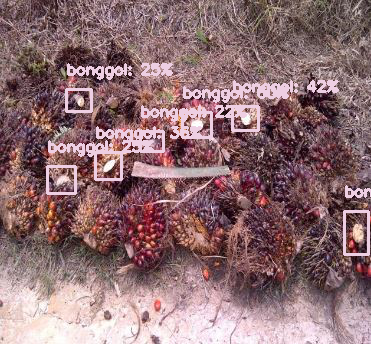

In [ ]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/semai_gan/14-2021-04-21T07%3A11%3A28.801Z.JPG" #@param {type:"string"}
DETECTION_THRESHOLD = 0.2 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)